In [ ]:
!nvidia-smi

Wed Jun 15 08:09:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import os
import re
import collections

## Dataset

In [ ]:
!git clone https://github.com/SBU-CE/Deep-Learning.git
data = pd.read_csv('/content/taghche_5000.csv', encoding='utf-8')
data = data[['comment', 'rate']]
data.head()

Cloning into 'Deep-Learning'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 414 (delta 64), reused 23 (delta 11), pack-reused 265
Receiving objects: 100% (414/414), 16.43 MiB | 12.51 MiB/s, done.
Resolving deltas: 100% (149/149), done.


,comment,rate
0,اسم کتاب No one writes to the Colonel\nترجمش...,0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2
4,کتاب خوبی است,3


In [ ]:
data['rate'] = data['rate'].apply(lambda r: r if r < 6 else None)
data = data.dropna(subset=['rate'])
data = data.dropna(subset=['comment'])
data = data.drop_duplicates(subset=['comment'], keep='first')
data = data.reset_index(drop=True)

### Normalization / Preprocessing

**<font color=black> For simplicity, Transforming the rate in a range of 0.0 to 5.0 to a binary form of negative (0) or positive (1) with a threshold. If the rate is less than 3.0, it labeled as negative otherwise specified as positive.</font>**

In [ ]:
def rate_to_label(rate, threshold=3.0):
    if rate <= threshold:
        return 'negative'
    else:
        return 'positive'


data['label'] = data['rate'].apply(lambda t: rate_to_label(t, 3.0))
labels = list(sorted(data['label'].unique()))
data.head()

,comment,rate,label
0,اسم کتاب No one writes to the Colonel\nترجمش...,0,negative
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5,positive
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5,positive
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2,negative
4,کتاب خوبی است,3,negative


**<font color=red> </font>**

**<font color=black>- fixing unicodes</font>**

**<font color=black>- removing specials like a phone number, email, url, new lines, ...</font>**

**<font color=black>- cleaning HTMLs</font>**

**<font color=black>- normalizing</font>**

**<font color=black>- removing emojis</font>**

**<font color=black>- removing extra spaces, hashtags</font>**

In [ ]:
!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

import hazm
from cleantext import clean

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def cleaning(text):
    text = text.strip()
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emojis
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf" #Unicode Character 'EJECT SYMBOL'
        u"\u23e9" #Unicode Character 'BLACK RIGHT-POINTING DOUBLE TRIANGLE'
        u"\u231a" #Unicode Character 'WATCH'
        u"\u3030" #Unicode Character 'WAVY DASH'
        u"\ufe0f" #Unicode VARIATION SELECTOR-16
        u"\u2069" #Unicode Character 'POP DIRECTIONAL ISOLATE'
        u"\u2066" #Unicode Character 'LEFT-TO-RIGHT ISOLATE'
        u"\u2068" #Unicode Character 'FIRST STRONG ISOLATE'
        u"\u2067" #Unicode Character 'RIGHT-TO-LEFT ISOLATE'
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r'', text)
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    return text

     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 64.0 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 59.2 MB/s 
     |████████████████████████████████| 316 kB 4.9 MB/s 
     |████████████████████████████████| 1.4 MB 68.8 MB/s 
     |████████████████████████████████| 233 kB 69.3 MB/s 
     |████████████████████████████████| 175 kB 4.9 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 235 kB 63.0 MB/s 


In [ ]:
# cleaning comments
data['cleaned_comment'] = data['comment'].apply(cleaning)

**<font color=black> Calculate the Length of Comments based on their Words</font>**

In [ ]:
data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

**<font color=black> Remove Comments with the Length of Fewer than 3 Words & More than 256 Words</font>**

In [ ]:
minlim, maxlim = 3, 256
data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
data = data.dropna(subset=['cleaned_comment_len_by_words'])
data = data.reset_index(drop=True)
data.head()

,comment,rate,label,cleaned_comment,cleaned_comment_len_by_words
0,اسم کتاب No one writes to the Colonel\nترجمش...,0,negative,اسم کتاب no one writes to the colonel ترجمش می...,47
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5,positive,طاقچه عزیز، نام کتاب «کسی به سرهنگ نامه نمینوی...,20
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5,positive,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,45
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2,negative,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,20
4,کتاب خوبی است,3,negative,کتاب خوبی است,3


In [ ]:
data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,اسم کتاب no one writes to the colonel ترجمش می...,negative
1,طاقچه عزیز، نام کتاب «کسی به سرهنگ نامه نمینوی...,positive
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,positive
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,negative
4,کتاب خوبی است,negative


### Handling Unbalanced Data

In [ ]:
fig = go.Figure()
groupby_label = data.groupby('label')['label'].count()
fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='count',
    bargap=0.3,
    bargroupgap=0.3)

fig.show()

In [ ]:
negative_samples = data[data['label'] == 'negative']
positive_samples = data[data['label'] == 'positive']
cut_point = min(len(negative_samples), len(positive_samples))

if cut_point <= len(negative_samples):
    negative_samples = negative_samples.sample(n=cut_point).reset_index(drop=True)

if cut_point <= len(positive_samples):
    positive_samples = positive_samples.sample(n=cut_point).reset_index(drop=True)

new_data = pd.concat([negative_samples, positive_samples])
new_data = new_data.sample(frac=1).reset_index(drop=True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  2492 non-null   object
 1   label    2492 non-null   object
dtypes: object(2)
memory usage: 39.1+ KB


In [ ]:
fig = go.Figure()
groupby_label = new_data.groupby('label')['label'].count()
fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))
fig.update_layout(
    title_text='Distribution of label within comments [NEW DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='count',
    bargap=0.3,
    bargroupgap=0.3)
fig.show()

## Train, Validation and Test split



In [ ]:
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(2017, 3)
(225, 3)
(250, 3)


![BERT INPUTS](https://res.cloudinary.com/m3hrdadfi/image/upload/v1595158991/kaggle/bert_inputs_w8rith.png)

As you may know, the BERT model input is a combination of 3 embeddings.
- Token embeddings: WordPiece token vocabulary (WordPiece is another word segmentation algorithm, similar to BPE)
- Segment embeddings: for pair sentences [A-B] marked as $E_A$ or $E_B$ mean that it belongs to the first sentence or the second one.
- Position embeddings: specify the position of words in a sentence

## PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Configuration

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}
print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


**<font color=black> Setup the Tokenizer and Configuration</font>**

In [ ]:
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
from transformers import BertConfig, BertTokenizer

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })
print(config.to_json_string())

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



### Input Embeddings

### Dataset

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')

        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        return inputs

def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len,
        label_list=label_list)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = ['negative', 'positive']
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), test['label'], tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

### Model

**<font color=black> Complete forward function</font>**

In [ ]:
from transformers import BertModel

class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH, return_dict=False)
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        output = self.dropout(output)
        logits = self.classifier(output)
        return logits

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
pt_model = None
!nvidia-smi

Wed Jun 15 12:08:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)
print('pt_model', type(pt_model))

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


### Training

In [ ]:
from sklearn.metrics import f1_score

def acc_and_f1(y_true, y_pred, average='weighted'):
    # Define Accuracy and F1-score
    acc = (y_true == y_pred).mean()
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)
    return y, loss

def eval_op(model, data_loader, loss_fn):
    model.eval()
    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):

            # Define input_ids, attention_mask, token_type_ids, targets
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']
            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)
            # calculate the batch loss
            loss = loss_fn(outputs, targets)
            # accumulate all the losses
            losses.append(loss.item())
            y_pred.extend(preds)
            y_true.extend(targets)
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss

def train_op(model,
             data_loader,
             loss_fn,
             optimizer,
             scheduler,
             step=0,
             print_every_step=100,
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None,
             clip=0.0):

    model.train()
    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1
        # Define input_ids, attention_mask, token_type_ids, targets
        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']
        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)
        # calculate the batch loss
        loss = loss_fn(outputs, targets)
        # accumulate all the losses
        losses.append(loss.item())
        # compute gradient of the loss with respect to model parameters
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        # perform optimization step
        optimizer.step()
        # perform scheduler step
        scheduler.step()
        y_pred.extend(preds)
        y_true.extend(targets)
        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)
    return train_y, train_loss, step, eval_loss_min

**<font color=black> Define Optimizer, Scheduler & Loss Function</font>**

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss()
step = 0
eval_loss_min = np.Inf
log = collections.defaultdict(list)

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])
        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])
        print(statement)
        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        return eval_loss_min
    return eval_cb

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/10 [00:00<?, ?it/s]

Training... :   0%|          | 0/127 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

Training... :   0%|          | 0/127 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

Training... :   0%|          | 0/127 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

Training... :   0%|          | 0/127 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

Training... :   0%|          | 0/127 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

Training... :   0%|          | 0/127 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

Training... :   0%|          | 0/127 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

Training... :   0%|          | 0/127 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 8/10...Step: 1000...Train Loss: 0.062233...Train Acc: 0.979...Valid Loss: 1.300109...Valid Acc: 0.693...
Validation loss decreased (inf --> 1.300109).  Saving model ...


Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

Training... :   0%|          | 0/127 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

Training... :   0%|          | 0/127 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/15 [00:00<?, ?it/s]

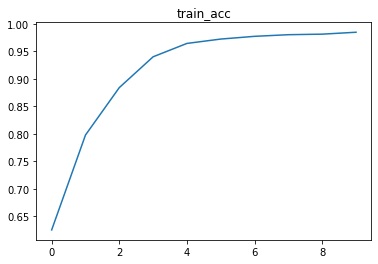

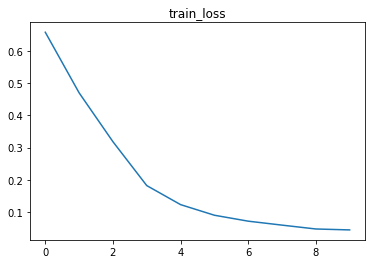

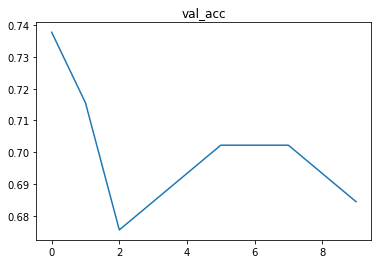

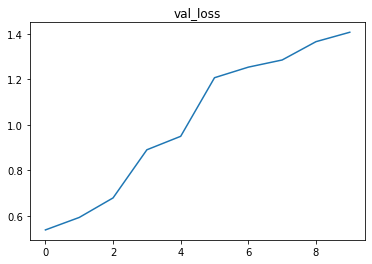

In [ ]:
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    # Define train_y, train_loss, step, eval_loss_min using train_op
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model,
        data_loader=train_data_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        step=step,
        print_every_step=EEVERY_EPOCH,
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader,
        clip=CLIP)
    # Define train_score using acc_and_f1
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    # Define eval_y, eval_loss using eval_op
    eval_y, eval_loss = eval_op(
        model=pt_model,
        data_loader=valid_data_loader,
        loss_fn=loss_fn)
    # Define eval_score using acc_and_f1
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    # Save Accuracy and Loss values
    log['train_acc'].append(train_score['acc'])
    log['train_loss'].append(train_loss)
    log['val_acc'].append(eval_score['acc'])
    log['val_loss'].append(eval_loss)
# Diagram
import matplotlib.pyplot as plt
import numpy as np
xpoints = np.arange(EPOCHS)
ypoints = log['train_acc']
plt.plot(xpoints, ypoints)
plt.title("train_acc")
plt.show()

ypoints = log['train_loss']
plt.plot(xpoints, ypoints)
plt.title("train_loss")
plt.show()

ypoints = log['val_acc']
plt.plot(xpoints, ypoints)
plt.title("val_acc")
plt.show()

ypoints = log['val_loss']
plt.plot(xpoints, ypoints)
plt.title("val_loss")
plt.show()

### Prediction

In [ ]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    predictions = []
    prediction_probs = []
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            # Define input_ids, attention_mask, token_type_ids
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))
    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()
    return predictions, prediction_probs

In [ ]:
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)
print(preds.shape, probs.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

(250,) (250, 2)


In [ ]:
from sklearn.metrics import classification_report
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds
print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print(classification_report(y_test, y_pred, target_names=label_list))

F1: 0.6599945599129585
              precision    recall  f1-score   support

    negative       0.66      0.66      0.66       125
    positive       0.66      0.66      0.66       125

    accuracy                           0.66       250
   macro avg       0.66      0.66      0.66       250
weighted avg       0.66      0.66      0.66       250

